In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

In [3]:
# df_patients = pd.read_csv("data-p2/patients.csv")
# df_mimic3d = pd.read_csv("data-p2/mimic3d.csv")

# df = df_mimic3d[df_mimic3d['hadm_id'].isin(df_patients['hadm_id'])]

# # df.to_csv("data-p2/filtered_mimic3d.csv", index=False)

df = pd.read_csv("data-p2/filtered_mimic3d.csv")
print(df.head())

   hadm_id gender  age  LOSdays admit_type             admit_location  \
0   100003      M   59     4.04  EMERGENCY       EMERGENCY ROOM ADMIT   
1   100011      M   21    14.38  EMERGENCY  CLINIC REFERRAL/PREMATURE   
2   100036      F   82    10.04  EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3   100060      F   48     4.46  EMERGENCY       EMERGENCY ROOM ADMIT   
4   100069      F   33     0.71  EMERGENCY  PHYS REFERRAL/NORMAL DELI   

                                     AdmitDiagnosis insurance       religion  \
0                                    UPPER GI BLEED   Private  NOT SPECIFIED   
1  MOTOR VEHICLE ACCIDENT WITH UNSPECIFIED INJURIES  Medicaid  NOT SPECIFIED   
2                                               CHF  Medicare       CATHOLIC   
3                                          OVERDOSE  Medicare       CATHOLIC   
4                               ORGAN DONOR ACCOUNT   Private       CATHOLIC   

  marital_status  ... NumMicroLabs  NumNotes  NumOutput  NumRx NumProcEvents  \


### variable investigation

In [3]:
df.dtypes

hadm_id               int64
gender               object
age                   int64
LOSdays             float64
admit_type           object
admit_location       object
AdmitDiagnosis       object
insurance            object
religion             object
marital_status       object
ethnicity            object
NumCallouts         float64
NumDiagnosis        float64
NumProcs            float64
AdmitProcedure       object
NumCPTevents        float64
NumInput            float64
NumLabs             float64
NumMicroLabs        float64
NumNotes            float64
NumOutput           float64
NumRx               float64
NumProcEvents       float64
NumTransfers        float64
NumChartEvents      float64
ExpiredHospital       int64
TotalNumInteract    float64
LOSgroupNum           int64
dtype: object

In [51]:
df["admit_type"].value_counts()

admit_type
EMERGENCY    2111
NEWBORN       408
ELECTIVE      385
URGENT         72
Name: count, dtype: int64

In [5]:
df["admit_location"].nunique()

8

In [14]:
df["AdmitProcedure"].value_counts()

AdmitProcedure
na                          397
Cont inv mec ven <96 hrs    183
Vaccination NEC             139
Venous cath NEC             104
Circumcision                 85
                           ... 
Gastric operation NEC         1
Spinal canal inject NEC       1
Hepatotomy                    1
Opn lft hemicolectmy NEC      1
Debrid opn fx-femur           1
Name: count, Length: 417, dtype: int64

In [7]:
df["AdmitDiagnosis"].nunique()

1302

                                               Category  Count  Cluster
1298  MITRAL REGURGITATION\CORONARY ARTERY BYPASS GR...      1        0
1205                ACUTE SHORTNESS OF BREATH;CONFUSION      1        0
1206                                PROSTATE CANCER/SDA      1        0
1207                                  MYASTHENIA GRAVIS      1        0
1208  CORONARY ARTERY DISEASE\PERCUTANEOUS CORONARY ...      1        0
...                                                 ...    ...      ...
15                                DIABETIC KETOACIDOSIS     19        1
1                                             PNEUMONIA     83        1
31                           S/P MOTOR VEHICLE ACCIDENT     11        1
2                                                SEPSIS     65        1
3                              CONGESTIVE HEART FAILURE     51        1

[1302 rows x 3 columns]


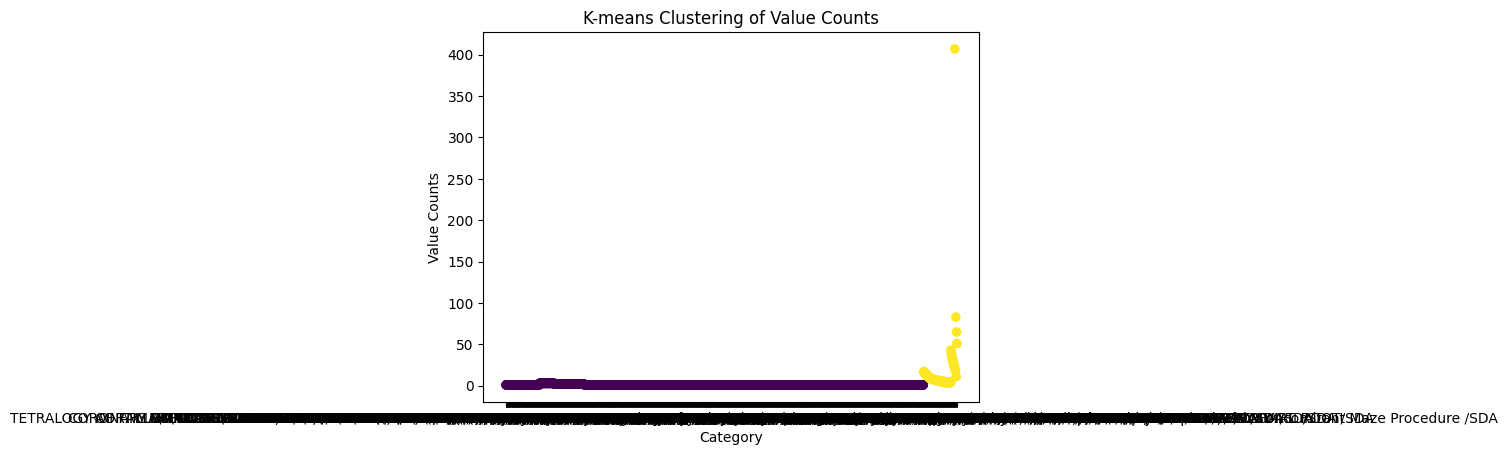

In [45]:
from sklearn.cluster import KMeans
# Get value counts
value_counts = df["AdmitDiagnosis"].value_counts()

log_value_counts = np.log1p(value_counts)

value_counts_reshaped = log_value_counts.values.reshape(-1, 1)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(value_counts_reshaped)



# Get the cluster labels and cluster centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Add the cluster labels to the original value counts
value_counts_df = pd.DataFrame({
    'Category': value_counts.index,
    'Count': value_counts.values,
    'Cluster': labels
})

# Sort by the cluster for easy viewing
value_counts_df.sort_values(by='Cluster', inplace=True)

# Print the results
print(value_counts_df)

# Plot the clusters
plt.scatter(value_counts_df['Category'], value_counts_df['Count'], c=value_counts_df['Cluster'], cmap='viridis')
plt.xlabel('Category')
plt.ylabel('Value Counts')
plt.title('K-means Clustering of Value Counts')
plt.show()

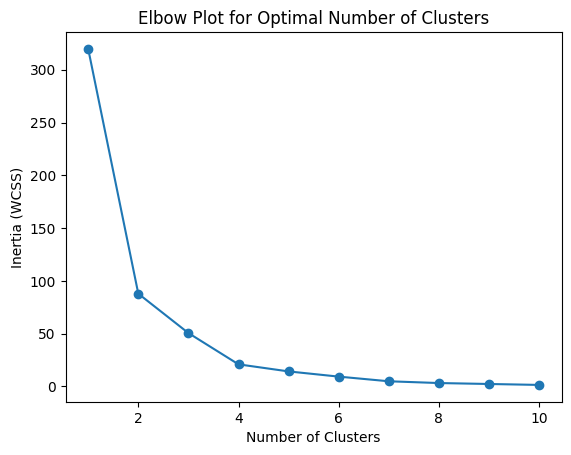

In [48]:
# Create an empty list to store the inertia (WCSS) values
inertia_values = []

# Run K-means for different numbers of clusters (e.g., 1 to 10)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(value_counts_reshaped)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow plot
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.show()

In [49]:
target_cluster = 1  # Assuming cluster 1 is the target cluster

# Get the categories in the target cluster
target_categories = value_counts[labels == target_cluster]

# Reshape the target cluster counts for re-clustering
target_counts_reshaped = target_categories.values.reshape(-1, 1)

# Apply K-means again to the target cluster (e.g., split it into 2 new clusters)
kmeans_target = KMeans(n_clusters=2, random_state=42)
kmeans_target.fit(target_counts_reshaped)

# Get the new labels for the target cluster
new_labels = kmeans_target.labels_

# Count how many categories are in each new sub-cluster
new_cluster_counts = pd.Series(new_labels).value_counts()

In [8]:
df["religion"].nunique()

16

In [9]:
df["insurance"].nunique()

5

In [10]:
df["marital_status"].nunique()

6

In [5]:
#df["ethnicity"].nunique()
df["ethnicity"].value_counts()

ethnicity
WHITE                             2063
BLACK/AFRICAN AMERICAN             270
UNKNOWN/NOT SPECIFIED              237
ASIAN                               91
HISPANIC OR LATINO                  82
OTHER                               69
UNABLE TO OBTAIN                    31
PATIENT DECLINED TO ANSWER          30
BLACK/CAPE VERDEAN                  15
MULTI RACE ETHNICITY                12
ASIAN - CHINESE                     12
WHITE - OTHER EUROPEAN               8
WHITE - RUSSIAN                      7
HISPANIC/LATINO - DOMINICAN          6
HISPANIC/LATINO - PUERTO RICAN       5
PORTUGUESE                           4
ASIAN - VIETNAMESE                   4
AMERICAN INDIAN/ALASKA NATIVE        4
BLACK/HAITIAN                        4
ASIAN - ASIAN INDIAN                 3
ASIAN - KOREAN                       2
ASIAN - CAMBODIAN                    2
ASIAN - OTHER                        2
MIDDLE EASTERN                       2
WHITE - BRAZILIAN                    2
ASIAN - FILIPIN

In [9]:
df["ethnicity_grouped"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
2971    NaN
2972    NaN
2973    NaN
2974    NaN
2975    NaN
Name: ethnicity_grouped, Length: 2976, dtype: object

In [12]:
df["gender"].nunique()

2

### ENCODING

In [1]:
# One-hot encode low-cardinality columns
#df_one_hot = pd.get_dummies(df[['gender', 'admit_type', 'admit_location','religion','insurance', 'marital_status','ethnicity',]], drop_first=True)
df_one_hot = pd.get_dummies(df[['gender', 'admit_type', 'admit_location','religion','insurance', 'marital_status','ethnicity']], drop_first=True)

# Binary encode high-cardinality columns
binary_encoder = ce.BinaryEncoder(cols=['AdmitDiagnosis', 'AdmitProcedure'], drop_invariant=True)
df_binary = binary_encoder.fit_transform(df[['AdmitDiagnosis', 'AdmitProcedure']])

# Select numeric columns
df_numeric = df.select_dtypes(include=['float64', 'int64']).drop(['hadm_id'], axis=1)

# Concatenate everything
df_concat = pd.concat([df_numeric, df_one_hot, df_binary], axis=1)

NameError: name 'pd' is not defined

In [59]:
df_concat.shape

(2976, 104)

### sparse PCA

In [12]:
import numpy as np
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler

X = df_concat.drop(columns=['LOSdays']) # Replace with your actual variables
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan)
X_numeric = X.dropna()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SparsePCA
# n_components: Number of sparse components to extract
# alpha: Regularization parameter controlling sparsity (higher values enforce more sparsity)
spca = SparsePCA(n_components=2, alpha=1)

# Fit the model and transform the data
X_spca = spca.fit_transform(X_scaled)

# Components extracted
components = spca.components_

# Print the transformed data and components
print("Transformed Data (Sparse PCA):\n", X_spca)
print("\nSparse PCA Components:\n", components)


C:\Users\mairi\AppData\Local\Temp\ipykernel_39612\3458104671.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)


Transformed Data (Sparse PCA):
 [[-0.04312771  0.06362636]
 [ 1.03087252  0.39603933]
 [-0.68521348 -1.59646334]
 ...
 [ 1.52294672 -1.34954791]
 [-0.54443842 -0.54625193]
 [-0.3813928  -0.57588229]]

Sparse PCA Components:
 [[-0.00000000e+00 -1.04891902e-02  3.55774410e-01  3.47279609e-01
   2.39357080e-01  1.68565758e-01  3.63879191e-01  7.75041773e-02
   3.35034143e-01  1.36182285e-01  2.60865726e-01  1.80989170e-01
   3.47441666e-01  2.13486204e-01  1.75930064e-01  2.88876560e-01
  -9.30930160e-02 -0.00000000e+00  1.48123518e-02 -0.00000000e+00
  -2.32350207e-03  1.73682125e-02 -0.00000000e+00 -0.00000000e+00
  -1.12739350e-02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -3.02402398e-02 -0.00000000e+00
   2.51601096e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
   5.17106434e-03 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  3.36495225e-02 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  4.89660322e-02

In [13]:
for i, component in enumerate(components):
    print(f"Component {i+1}:")
    non_zero_indices = np.where(component != 0)[0]
    non_zero_vars = X.columns[non_zero_indices].tolist()
    print("  Non-zero variables:", non_zero_vars)
    print("  Coefficients:", component[non_zero_indices])

Component 1:
  Non-zero variables: ['NumCallouts', 'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'ExpiredHospital', 'TotalNumInteract', 'LOSgroupNum', 'admit_type_EMERGENCY', 'admit_type_URGENT', 'admit_location_CLINIC REFERRAL/PREMATURE', 'admit_location_PHYS REFERRAL/NORMAL DELI', 'religion_CATHOLIC', 'religion_EPISCOPALIAN', 'religion_JEWISH', 'religion_UNOBTAINABLE', 'insurance_Self Pay', 'marital_status_SINGLE', 'marital_status_WIDOWED', 'ethnicity_OTHER', 'ethnicity_UNABLE TO OBTAIN', 'ethnicity_WHITE', 'ethnicity_WHITE - RUSSIAN', 'AdmitDiagnosis_1', 'AdmitDiagnosis_2', 'AdmitDiagnosis_6', 'AdmitDiagnosis_10', 'AdmitProcedure_1', 'AdmitProcedure_2', 'AdmitProcedure_3', 'AdmitProcedure_4', 'AdmitProcedure_5', 'AdmitProcedure_7', 'AdmitProcedure_8']
  Coefficients: [-0.01048919  0.35577441  0.34727961  0.23935708  0.16856576  0.36387919
  0.07750418  0.33503414

In [50]:
print([i for i in df_concat.dtypes])

[dtype('int64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('int64'), dtype('float64'), dtype('int64'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype('bool'), dtype(

In [46]:
#df_concat.to_csv("data-p2/encoded_filtered_mimic3d.csv", index=False)

### variable combo exploration

In [1]:

df_binary = binary_encoder.fit_transform(df[['AdmitDiagnosis', 'AdmitProcedure']])

# Select numeric columns
df_numeric = df.select_dtypes(include=['float64', 'int64']).drop(['hadm_id'], axis=1)

# Concatenate everything
df_concat = pd.concat([df_numeric, df_one_hot, df_binary], axis=1)

NameError: name 'binary_encoder' is not defined

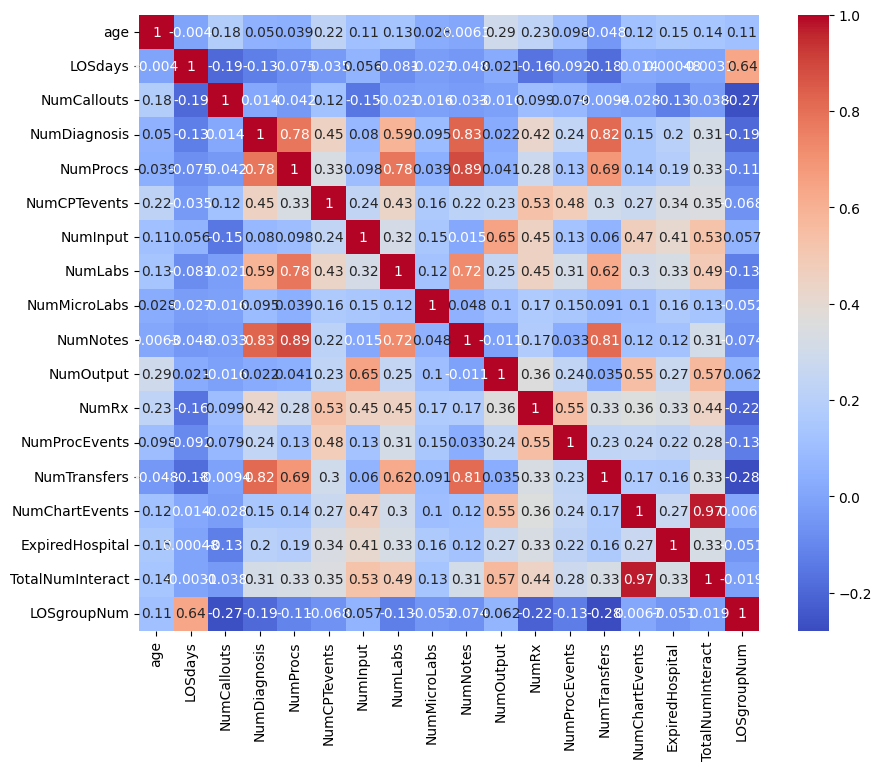

In [60]:
correlation_matrix = df_numeric.corr()
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

Number of notes is highly correlated with number of diagnoses, number of procedures, number of labs, and number of transfers - use this as a proxy for severity?

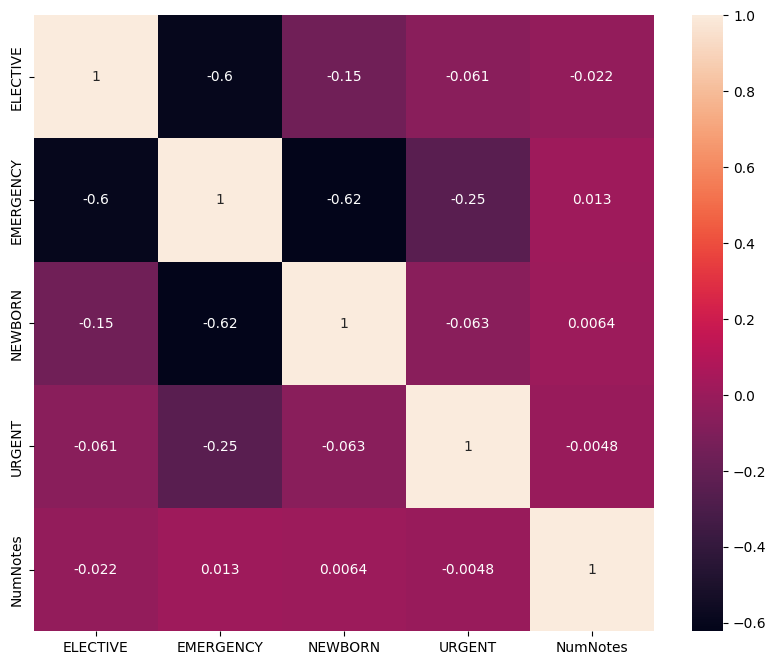

In [74]:
df_admit = pd.get_dummies(df['admit_type'], drop_first=False)
df_num1 = df_numeric['NumNotes']

df_numadmit = pd.concat([df_admit,df_num1],axis=1)
correlation_matrix = df_numadmit.corr()
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

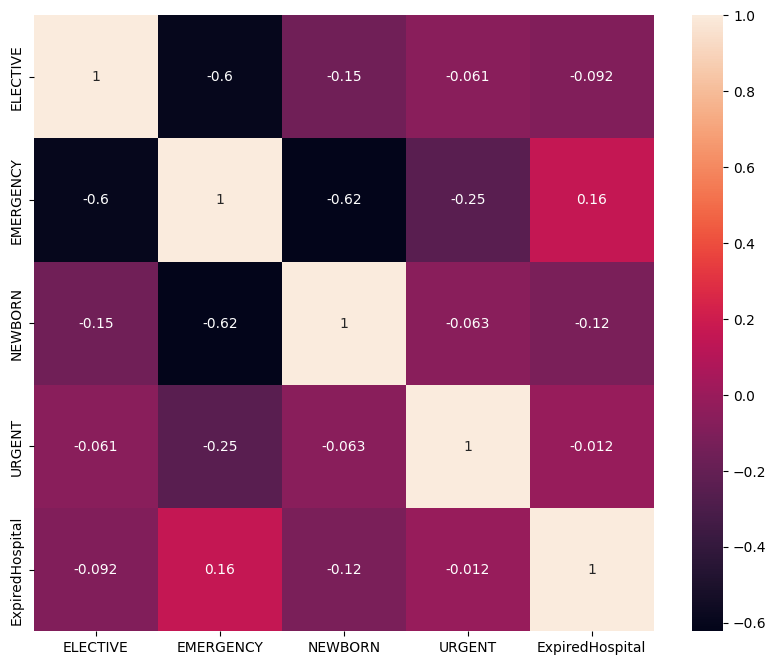

In [75]:
# df_admit = pd.get_dummies(df['admit_type'], drop_first=False)
df_dead = df_numeric['ExpiredHospital']

df_numd = pd.concat([df_admit,df_dead],axis=1)
correlation_matrix = df_numd.corr()
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

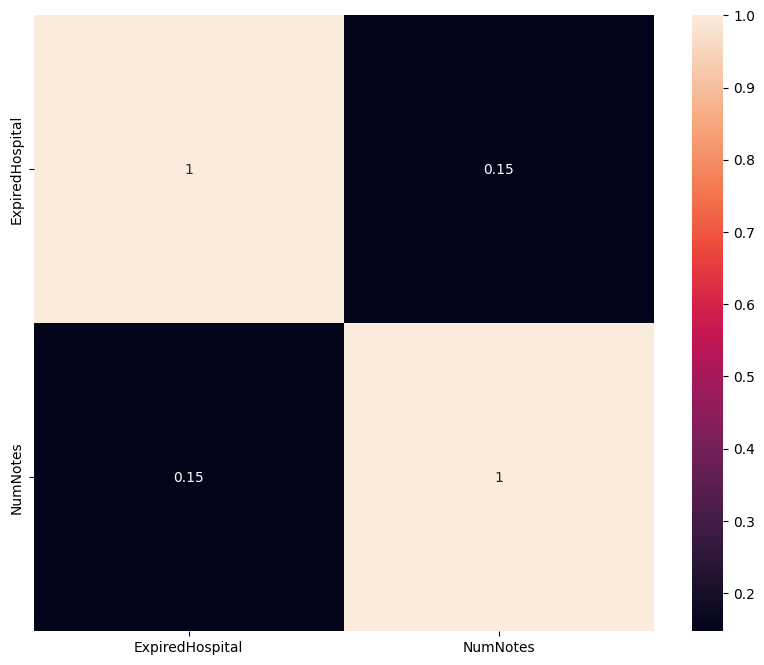

In [78]:
## Select only the 'ExpiredHospital' and 'NumNotes' columns
df_numeric_filtered = df_numeric[df_numeric['LOSdays']>1]
df_deadnotes2 = df_numeric_filtered[['ExpiredHospital','NumNotes']]

correlation_matrix = df_deadnotes2.corr()
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

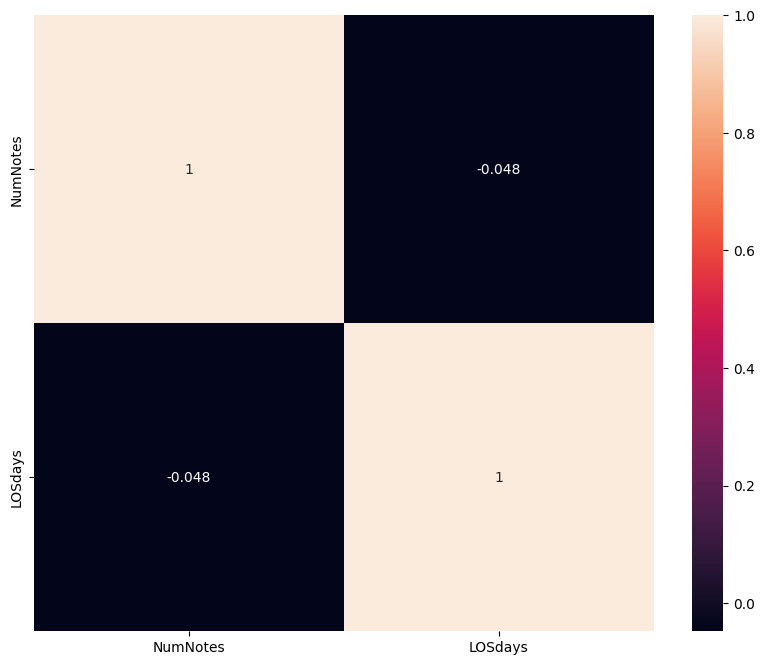

In [80]:
df_notesdays = df_numeric[['NumNotes','LOSdays']]
correlation_matrix = df_notesdays.corr()
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

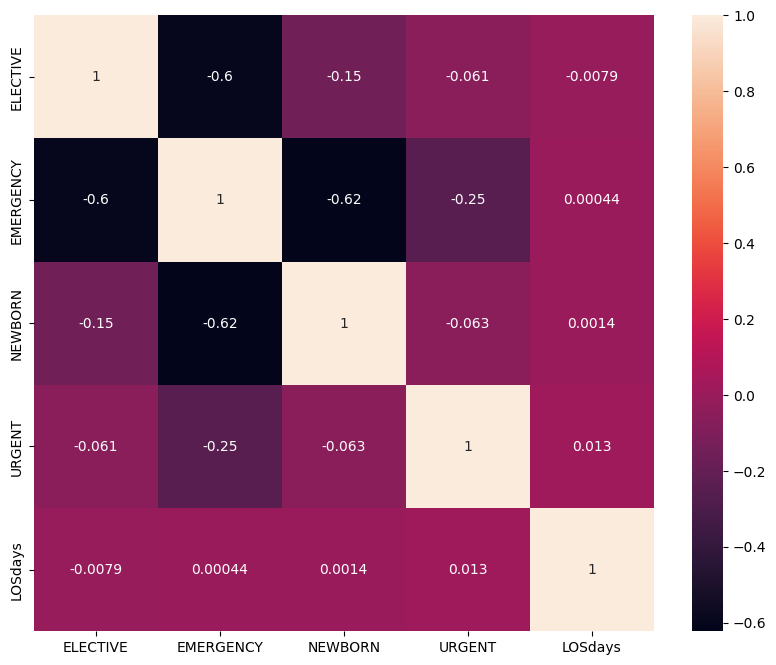

In [83]:
# df_admit = pd.get_dummies(df['admit_type'], drop_first=False)
df_days= df_numeric['LOSdays']

df_numdays = pd.concat([df_admit,df_days],axis=1)
correlation_matrix = df_numdays.corr()
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [7]:
correlation_matrix = df_concat.corr()
df_daycor = pd.DataFrame(correlation_matrix['LOSdays']).sort_values(by='LOSdays',ascending=False)

In [9]:
df_daycor.to_csv("LOSdays-corr.csv")

### scribbles

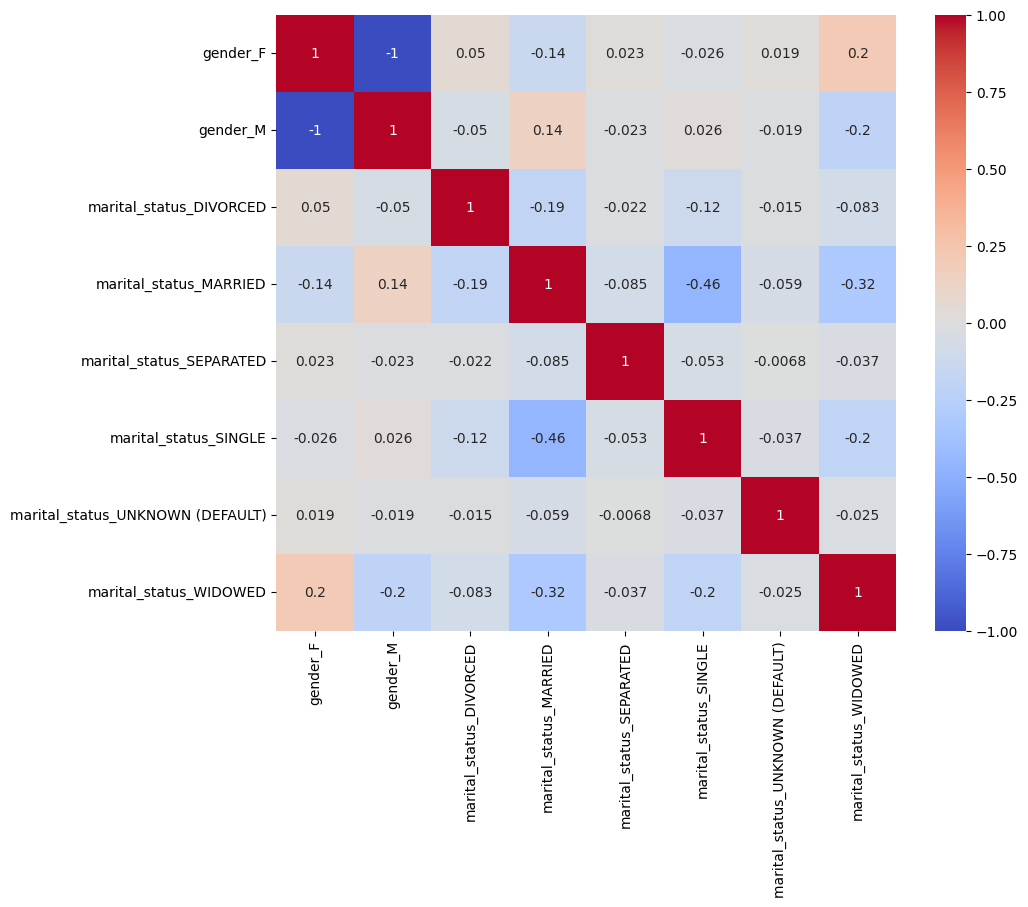

In [16]:
# One-hot encode low-cardinality columns
df_gm = pd.get_dummies(df[['gender', 'marital_status']], drop_first=False)
correlation_matrix = df_gm.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

In [77]:
corr_matrix = df_concat.corr().abs()

high_corr_pairs = corr_matrix[(corr_matrix > 0.8) & (corr_matrix != 1.0)]
high_corr_pairs = high_corr_pairs.dropna(how='all').dropna(how='all', axis=1)
print(high_corr_pairs)

                         age  NumDiagnosis  NumProcs  NumNotes  NumTransfers  \
age                      NaN           NaN       NaN       NaN           NaN   
NumDiagnosis             NaN           NaN       NaN  0.826799      0.817438   
NumProcs                 NaN           NaN       NaN  0.887547           NaN   
NumNotes                 NaN      0.826799  0.887547       NaN      0.814403   
NumTransfers             NaN      0.817438       NaN  0.814403           NaN   
NumChartEvents           NaN           NaN       NaN       NaN           NaN   
TotalNumInteract         NaN           NaN       NaN       NaN           NaN   
admit_type_NEWBORN  0.803002           NaN       NaN       NaN           NaN   

                    NumChartEvents  TotalNumInteract  admit_type_NEWBORN  
age                            NaN               NaN            0.803002  
NumDiagnosis                   NaN               NaN                 NaN  
NumProcs                       NaN               NaN  

In [73]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df_concat.drop(columns=['LOSdays']) # Replace with your actual variables
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan)
X_numeric = X.dropna()

# X_numeric = X.apply(pd.to_numeric, errors='coerce')
# X_numeric = X_numeric.dropna()

constant_columns = X_numeric.loc[:, X_numeric.apply(lambda x: x.nunique() == 1)]
X_numeric = X_numeric.drop(columns=constant_columns.columns)

X_numeric_with_constant = add_constant(X_numeric)

vif = pd.DataFrame()
vif["Variable"] = X_numeric_with_constant.columns
vif["VIF"] = [variance_inflation_factor(X_numeric_with_constant.values, i) for i in range(X_numeric_with_constant.shape[1])]

print(vif)


C:\Users\mairi\AppData\Local\Temp\ipykernel_18716\2277122856.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)
c:\Users\mairi\code\MAT-4376E-F24\.conda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


             Variable          VIF
0               const  1321.462802
1                 age     5.175739
2         NumCallouts          inf
3        NumDiagnosis          inf
4            NumProcs          inf
..                ...          ...
99   AdmitProcedure_4     1.172300
100  AdmitProcedure_5     1.188438
101  AdmitProcedure_6     1.244191
102  AdmitProcedure_7     1.174157
103  AdmitProcedure_8     1.247457

[104 rows x 2 columns]


In [75]:
vif.to_csv('vif.csv',index=False)

In [51]:
correlation_matrix = df_concat.corr()

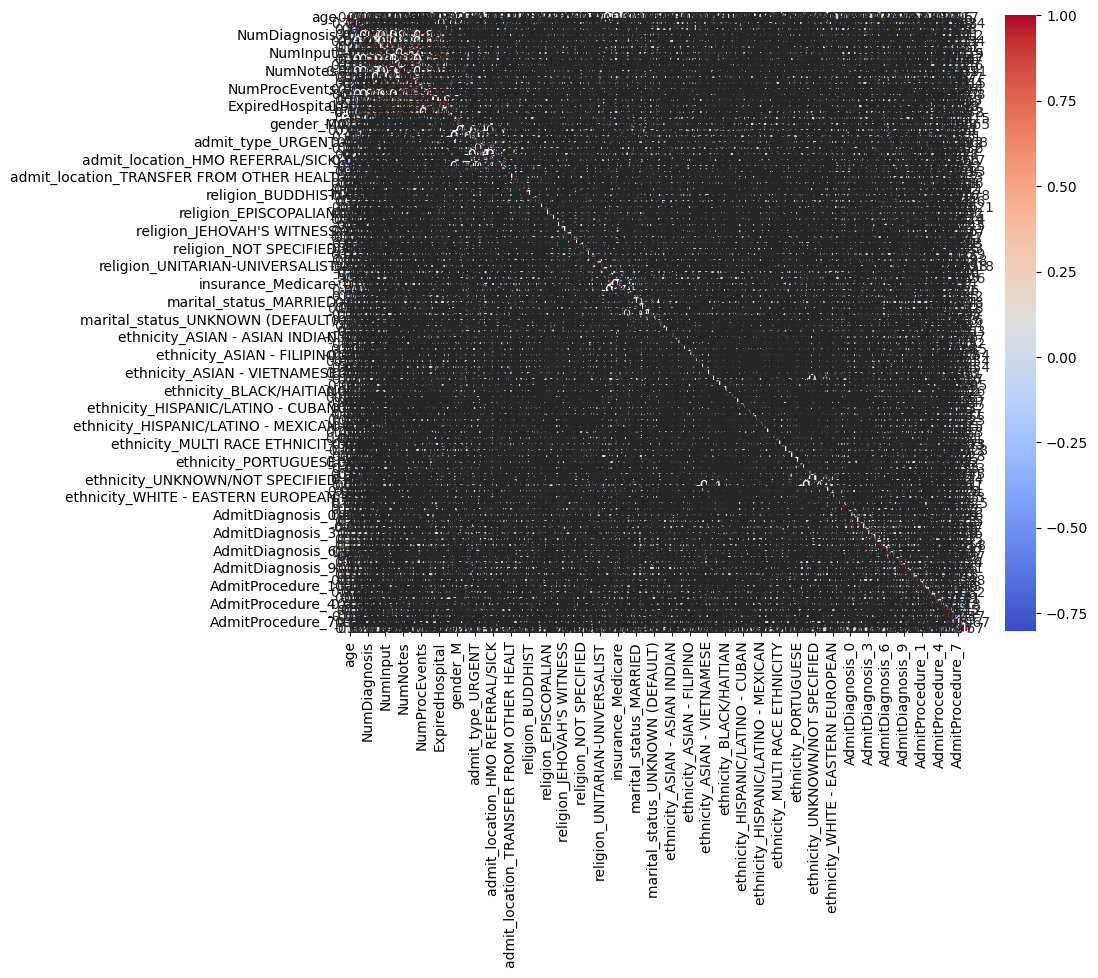

In [52]:
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()